In [1]:
%load_ext autoreload
%autoreload 2

import jax
jax.config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)

import numpy as np
import scipy.optimize

import ultraplot as uplt

## Fit the Data

In [2]:
import numpyro
from numpyro.infer import MCMC, NUTS

In [20]:
from des_y6_imsim_analysis import bump
from des_y6_imsim_analysis.utils import read_data

data = read_data("../../data/N_gamma_alpha_v2_statistical.hdf5")

model_module = bump

model_data = model_module.make_model_data(
    z=data.z,
    nzs=data.nzs,
    mn=data.mn,
    cov=data.cov,
    mn_pars=data.mn_pars,
    zbins=data.zbins,
    fixed_param_values={"w": 0.1, "g_b0": 0.0, "g_b1": 0.0, "g_b2": 0.0, "g_b3": 0.0},
    num_bins=9,
)

In [21]:
from des_y6_imsim_analysis.stats import measure_map

map_params = measure_map(
    model_module=model_module,
    model_data=model_data,
    seed=23141,
)

100%|██████████| 50000/50000 [00:24<00:00, 2071.45it/s, init loss: 239495.6089, avg. loss [47501-50000]: -123.1551]


In [22]:
from des_y6_imsim_analysis.stats import compute_model_chi2_info

chi2_info = compute_model_chi2_info(
    model_module=model_module,
    model_data=model_data,
    data=data,
    params=map_params,
)

print("chi2:", chi2_info['chi2'])
print("dof:", chi2_info['dof'])
print("p-value:", chi2_info['p_value'])
print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
    (chi2_info['model_mn'][:4] - 1).tolist(),
    (data.mn[:4] - 1).tolist(),
    (np.sqrt(np.diag(data.cov)[:4])).tolist(),
))

chi2: 3.8348942906809724
dof: 8
p-value: 0.8717040769021132
m vals:
    model: [-0.005871212432974837, 0.014553538745352146, 0.01695583258138922, 0.00977571245675346]
    data: [-0.006994349826206503, 0.016036566228740057, 0.017247239530250313, 0.009428620061380233]
     err: [0.004593226944328782, 0.006142812018330256, 0.005437871858005932, 0.009363355942622971]


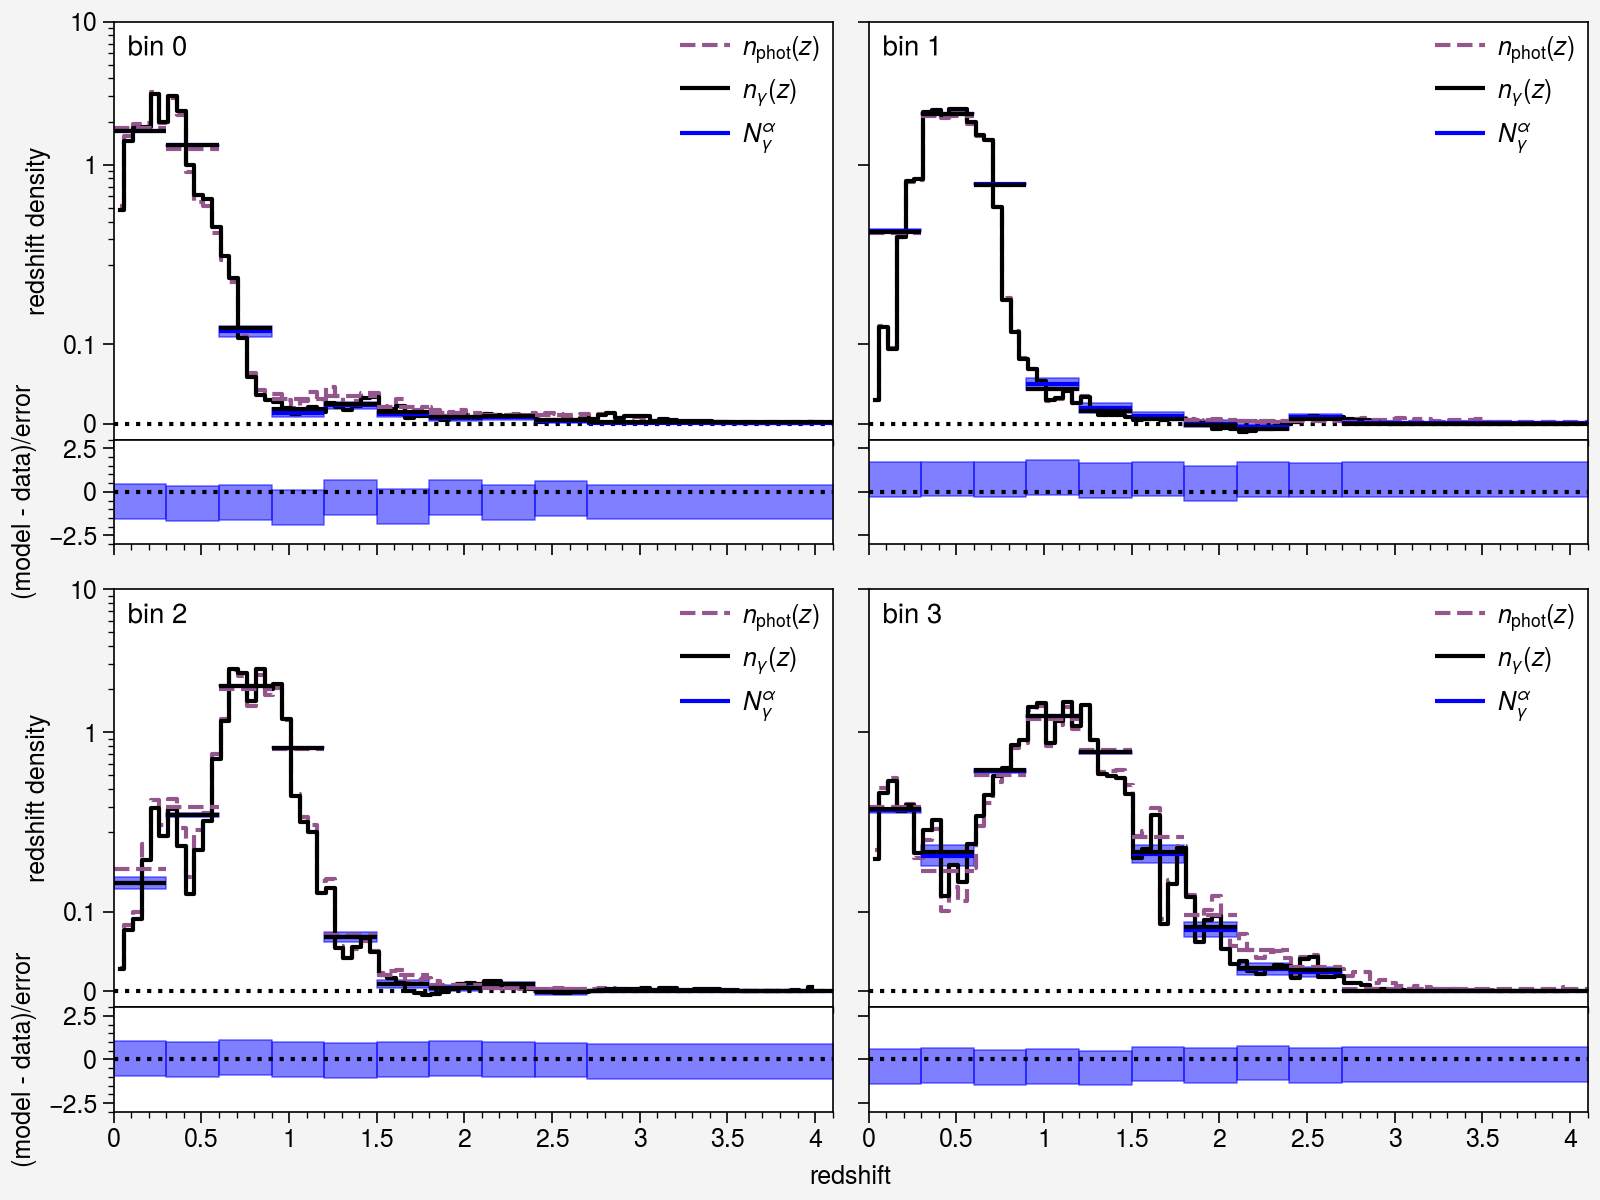

In [23]:
from des_y6_imsim_analysis.utils import plot_results

fig = plot_results(model_module=model_module, model_data=model_data, map_params=map_params)

In [24]:
from des_y6_imsim_analysis.stats import run_mcmc

mcmc = run_mcmc(
    model_module=model_module,
    model_data=model_data,
    init_params=map_params,
    seed=23141,
)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [25]:
mcmc.print_summary(exclude_deterministic=False)
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0     -0.13      0.01     -0.13     -0.15     -0.11   4691.66      1.00
     a0_b1     -0.01      0.05     -0.02     -0.10      0.07   3211.09      1.00
     a0_b2     -0.10      0.08     -0.10     -0.24      0.02   2676.57      1.00
     a0_b3     -0.14      0.07     -0.14     -0.25     -0.01   2713.12      1.00
     a1_b0      0.23      0.03      0.23      0.19      0.28   3979.99      1.00
     a1_b1      0.07      0.03      0.07      0.02      0.13   2628.54      1.00
     a1_b2     -0.21      0.07     -0.21     -0.33     -0.10   2159.60      1.00
     a1_b3      0.33      0.15      0.33      0.07      0.57   1895.39      1.00
     a2_b0     -0.11      0.12     -0.11     -0.30      0.09   2961.79      1.00
     a2_b1     -0.07      0.07     -0.07     -0.19      0.03   2352.13      1.00
     a2_b2      0.25      0.05      0.25      0.17      0.33   2191.87      1.00
     a2_b3     -0.03      0

In [26]:
from des_y6_imsim_analysis.utils import measure_m_dz

mdz = measure_m_dz(
    model_module=model_module,
    model_data=model_data,
    samples=samples,
    return_dict=True,
)

In [27]:
m_mn = [np.mean(mdz[f"m_b{i}"]) for i in range(4)]
m_sd = [np.std(mdz[f"m_b{i}"]) for i in range(4)]

dz_mn = [np.mean(mdz[f"dz_b{i}"]) for i in range(4)]
dz_sd = [np.std(mdz[f"dz_b{i}"]) for i in range(4)]

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -6.0 +/- 13.4    | -0.007 +/- 0.004 |
| 1   | +14.5 +/- 17.5    | -0.022 +/- 0.005 |
| 2   | +17.1 +/- 16.0    | +0.004 +/- 0.005 |
| 3   |  +9.4 +/- 27.5    | -0.034 +/- 0.009 |
|--------------------------------------------|


In [31]:
m_data = np.array([
    mdz[f"m_b{i}"] for i in range(4)
])

m_cov = np.cov(m_data)
m_corr = np.corrcoef(m_data)

In [54]:
print("m correlation matrix:\n", m_corr)

m correlation matrix:
 [[ 1.         -0.33180934 -0.13970179  0.01992394]
 [-0.33180934  1.         -0.12324332 -0.05400125]
 [-0.13970179 -0.12324332  1.         -0.28843444]
 [ 0.01992394 -0.05400125 -0.28843444  1.        ]]


# Compute Global `m`

```text
g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0

['statistical_weight']
b 	 w 			 w * R
0 	 37687408.52750142 	 31852021.778152555
1 	 32262590.501660284 	 25166769.445796162
2 	 36321284.070149 	 28019787.27996662
3 	 22979366.319672316 	 14517510.901062118

['statistical_weight', 'neighbor_weight']
b 	 w 			 w * R
0 	 36935272.88896909 	 31258164.71036748
1 	 33630265.55123577 	 26647800.06951995
2 	 37616957.073409796 	 29500162.15844555
3 	 23442093.917962722 	 15133209.390449103

['statistical_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38270056.368683755 	 32061262.610645365
1 	 35022342.94013908 	 27517630.555414688
2 	 30616116.814313516 	 23831877.593959697
3 	 25344050.202425964 	 15939348.02708475

['statistical_weight', 'neighbor_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38219183.82005287 	 32044282.53917939
1 	 36907118.418624476 	 29395545.456652362
2 	 32107396.97912129 	 25375065.53263439
3 	 25919483.487100307 	 16645228.651692027
```

```text
g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0

['statistical_weight']
b 	 w 			 w * R
0 	 37696158.10920723 	 31859661.180748507
1 	 32259102.894843798 	 25155195.522437155
2 	 36282302.28742035 	 27996436.095791794
3 	 22967280.29315682 	 14512115.373971423

['statistical_weight', 'neighbor_weight']
b 	 w 			 w * R
0 	 36954697.71678651 	 31274221.69176092
1 	 33637242.79052155 	 26646784.842271894
2 	 37562106.32644655 	 29462366.38122275
3 	 23429612.937475078 	 15128295.287524771

['statistical_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38274918.97872326 	 32064819.320034783
1 	 35019489.74908048 	 27508553.10837389
2 	 30578214.610265676 	 23808678.22404237
3 	 25330304.019322462 	 15934145.88475994

['statistical_weight', 'neighbor_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38234907.85639983 	 32057085.540191032
1 	 36914158.73922929 	 29396595.511817906
2 	 32053716.225799788 	 25337880.192668986
3 	 25903390.07112428 	 16639630.579854514
```

In [56]:
wR_plus = np.array([
    31852021.778152555,
    25166769.445796162,
    28019787.27996662,
    14517510.901062118,
])
wR_minus = np.array([
    31859661.180748507,
    25155195.522437155,
    27996436.095791794,
    14512115.373971423,
])

wR = (wR_plus + wR_minus)
wR /= np.sum(wR)

In [57]:
m = np.sum([mdz[f"m_b{i}"] * wR[i] for i in range(4)], axis=0)

print(
    "global m: %+5.1f +/- %-5.1f" % (
        np.mean(m) / 1e-3,
        np.std(m) / 1e-3 * 3,
    )
)

global m:  +7.9 +/- 6.3  
